In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [3]:
def load_data(dataset_path):
    hf = h5py.File(dataset_path, 'r')
    inputs = hf.get('inputs')
    targets = hf.get('targets')
    
    inputs = np.array(inputs)
    targets = np.array(targets)
    hf.close()
    
    return inputs, targets

In [4]:
inputs, targets = load_data(r"/content/drive/MyDrive/Thesis/Datasets/music_dataset_augmented.h5")

In [5]:
inputs.shape

(39944, 130, 13)

In [6]:
from sklearn.preprocessing import StandardScaler

inputs_testing = inputs.reshape(-1, inputs.shape[-1])
print(inputs_testing.shape)
scaler = StandardScaler()
X = scaler.fit_transform(inputs.reshape(-1, inputs.shape[-1])).reshape(inputs.shape)
print(f"Inputs = {inputs.shape}")

(5192720, 13)
Inputs = (39944, 130, 13)


In [7]:
# splitting the data
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.1, random_state=42)
input_train, input_val, target_train, target_val   = train_test_split(input_train, target_train, test_size=0.1, random_state=42)
print(len(input_train), len(input_test), len(input_val))

32354 3995 3595


In [8]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu', kernel_regularizer = keras.regularizers.l2(0.005)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 dense (Dense)               (None, 512)               865792    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

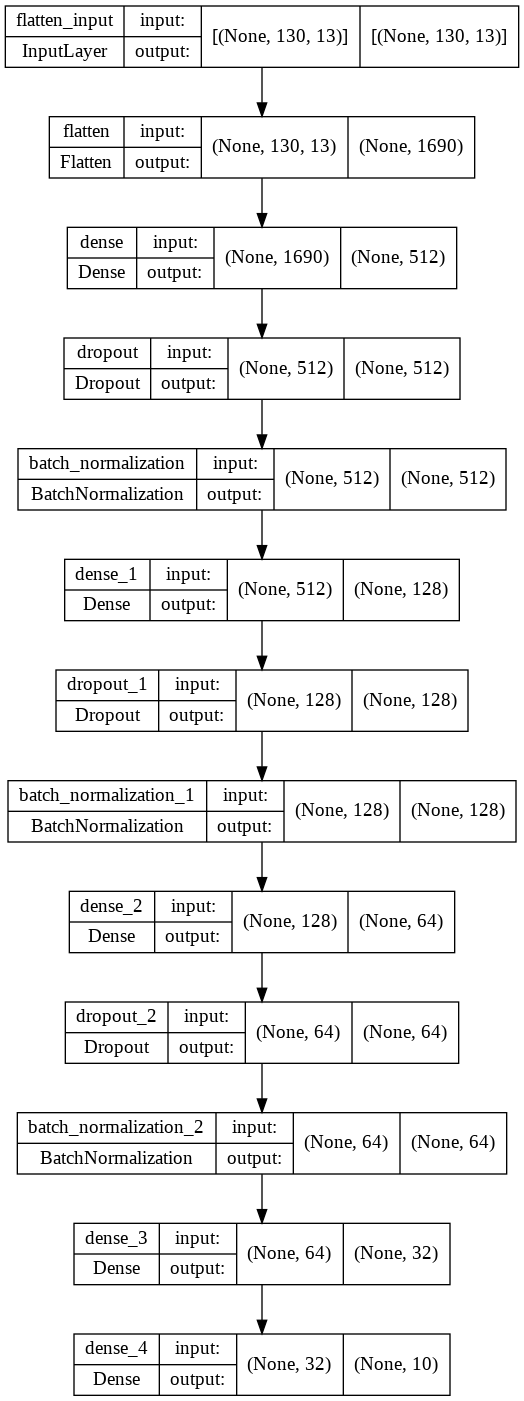

In [10]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, show_shapes=True, show_layer_names=True, to_file='/content/drive/MyDrive/Thesis/Models/ann_model_plot.png')#, to_file='/content/drive/MyDrive/Thesis/Models/ann_model_plot.png'

In [ ]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(learning_rate = 1e-4)

In [ ]:
early_stop  = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr   = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["sparse_categorical_accuracy"])

hist = model.fit(
    input_train, target_train,
    validation_data=(input_val, target_val),
    epochs = 100,
    batch_size = 32,
    callbacks = [
        reduce_lr,
        early_stop
    ]
)

Epoch 1/100
1012/1012 [==============================] - 17s 9ms/step - loss: 6.2077 - sparse_categorical_accuracy: 0.1929 - val_loss: 5.4987 - val_sparse_categorical_accuracy: 0.3138 - lr: 1.0000e-04
Epoch 2/100
1012/1012 [==============================] - 8s 8ms/step - loss: 5.2559 - sparse_categorical_accuracy: 0.2681 - val_loss: 4.7132 - val_sparse_categorical_accuracy: 0.3691 - lr: 1.0000e-04
Epoch 3/100
1012/1012 [==============================] - 8s 8ms/step - loss: 4.5353 - sparse_categorical_accuracy: 0.3040 - val_loss: 4.0582 - val_sparse_categorical_accuracy: 0.3981 - lr: 1.0000e-04
Epoch 4/100
1012/1012 [==============================] - 8s 8ms/step - loss: 3.9615 - sparse_categorical_accuracy: 0.3295 - val_loss: 3.5639 - val_sparse_categorical_accuracy: 0.4142 - lr: 1.0000e-04
Epoch 5/100
1012/1012 [==============================] - 8s 8ms/step - loss: 3.5067 - sparse_categorical_accuracy: 0.3454 - val_loss: 3.1740 - val_sparse_categorical_accuracy: 0.4136 - lr: 1.0000e-04

In [ ]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

125/125 [==============================] - 0s 4ms/step - loss: 1.2690 - sparse_categorical_accuracy: 0.6390
Test accuracy: 0.6390488147735596


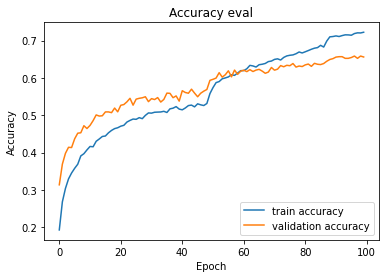

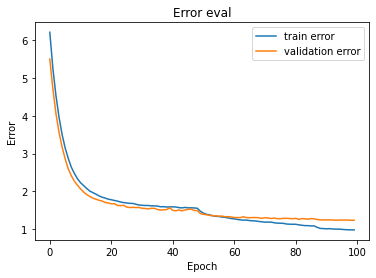

In [ ]:
plt.plot(hist.history["sparse_categorical_accuracy"], label="train accuracy")
plt.plot(hist.history["val_sparse_categorical_accuracy"], label="validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy eval")
plt.show()

plt.plot(hist.history["loss"], label="train error")
plt.plot(hist.history["val_loss"], label="validation error")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(loc="upper right")
plt.title("Error eval")
plt.show()

In [ ]:
target_predict_prob = model.predict(input_test)

target_predict = []
for i in target_predict_prob:
    target_predict.append(np.argmax(i))

target_predict = np.array(target_predict)

In [ ]:
print(target_predict.shape)
print(target_test.shape)

(3995,)
(3995,)


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

conf_matrix = confusion_matrix(target_test, target_predict).ravel()
print('Confusion matrix:\n', conf_matrix)
print()
cls_report = classification_report(target_test, target_predict)
print('Classification report: \n', cls_report)

Confusion matrix:
 [246  35  12  49   9   7   4  22  33  18  24 217   6  71   3   5   6  19
  41   9   3  10 249  45  21  21   5  17   2   5  39  61  21 186  15  14
   5  22  19  22  12   8  15  17 228  29   8  49   6   8   7  18  21  28
  18 301   6   7   4   1   0   6   0   9   0   1 330   3  44   0  15  19
  32  12  32  13   5 255  15   2  21  53   2  25   1   6  47  10 221   1
  20   4   5  42   7   3   0   2   3 320]

Classification report: 
               precision    recall  f1-score   support

           0       0.64      0.57      0.60       435
           1       0.50      0.54      0.52       401
           2       0.69      0.66      0.67       378
           3       0.38      0.46      0.42       404
           4       0.68      0.60      0.64       380
           5       0.75      0.73      0.74       411
           6       0.79      0.84      0.82       393
           7       0.63      0.64      0.63       400
           8       0.57      0.57      0.57       387
       